In [55]:
import torch
import jaxtyping
import tqdm
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available()
                    #   else "mps" if torch.backends.mps.is_available()
                      else "cpu")

# Number of features (aka d0 as we're not doing superposition input)
m = 100

# Feature sparsity
k = 3

# Hidden dims
d = 1000

# Relative importance of non-zero outputs
alpha = 1


class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(m, d)
        self.relu = torch.nn.ReLU()
        # self.relu = torch.nn.LeakyReLU(0.1)
        self.linear2 = torch.nn.Linear(d, m**2)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [56]:
def random_sparse_inputs(batch_size):
    x = torch.zeros(batch_size, m, device=device)

    # For each item in batch, randomly select k indices to set to 1
    # for i in range(batch_size):
    #     # Get k random indices between 0 and m-1
    #     indices = torch.randperm(m)[:k]
    #     x[i, indices] = 1

    indices = torch.multinomial(torch.ones(batch_size, m, device=device), k, replacement=False)
    x.scatter_(1, indices, 1)
    return x

def compute_expected(inputs):
    batch_size = inputs.shape[0]
    y = torch.zeros(batch_size, m, m, device=device)
    y = inputs[:, None, :] * inputs[:, :, None]
    y[:, range(m), range(m)] = 0
    y = y.view(batch_size, m**2)
    return y




In [57]:
model = MyModel()
model.to(device)

MyModel(
  (linear): Linear(in_features=100, out_features=1000, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (linear2): Linear(in_features=1000, out_features=10000, bias=True)
)

In [58]:
device

device(type='cuda')

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


# Training parameters
n_epochs = 300
batch_size = 10000

# Training loop
progress_bar = tqdm.tqdm(range(n_epochs))
for epoch in progress_bar:
    # Generate random batch of sparse inputs
    inputs = random_sparse_inputs(batch_size)
    
    # Compute expected outputs
    targets = compute_expected(inputs)
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(inputs)
    
    # Compute loss
    loss = criterion(outputs, targets)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    progress_bar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')


Epoch [228/300], Loss: 0.000535:  76%|███████▌  | 228/300 [00:47<00:15,  4.77it/s]

In [110]:
# Construct model
import math
def construct_model(p=None):
    p = math.log(m)**2/math.sqrt(d) if p is None else p
    # expected_intersection = p*p*d
    # expected_false_positives = (k-1)*p
    # print(f"{p=}")
    # print(f"{expected_intersection=} {expected_false_positives=}")
    model = MyModel()
    model.linear.weight.data = (torch.rand(d, m, device=device) < p).float()
    model.linear.bias.data = -torch.ones(d, device=device)
    model.linear2.bias.data = torch.zeros(m**2, device=device)
    weights2 = torch.zeros(m, m, d, device=device)
    l = model.linear.weight.data
    for i in range(m):
        for j in range(m):
            if i == j:
                continue
            # find intersecting set
            s = l[:, i] * l[:, j]
            ssum = s.sum()
            weights2[i, j, :] =  s / ssum if ssum > 0 else torch.zeros_like(s)
    model.linear2.weight.data = weights2.reshape(m**2, d)
    return model
# model = construct_model(0.1)



Test Loss: 0.000604
tensor([[ 0.0104,  0.0321,  0.0370,  0.0069,  0.0218,  0.0105],
        [ 0.0345, -0.0049,  0.0315,  0.0161,  0.0107,  0.0204],
        [ 0.0388,  0.0248, -0.0078,  0.0148,  0.0126,  0.0180],
        [ 0.0151,  0.0158,  0.0173,  0.0014,  0.0058,  0.0002],
        [ 0.0132,  0.0072,  0.0075,  0.0048,  0.0013, -0.0010],
        [ 0.0089,  0.0187,  0.0035,  0.0135, -0.0030, -0.0067]])


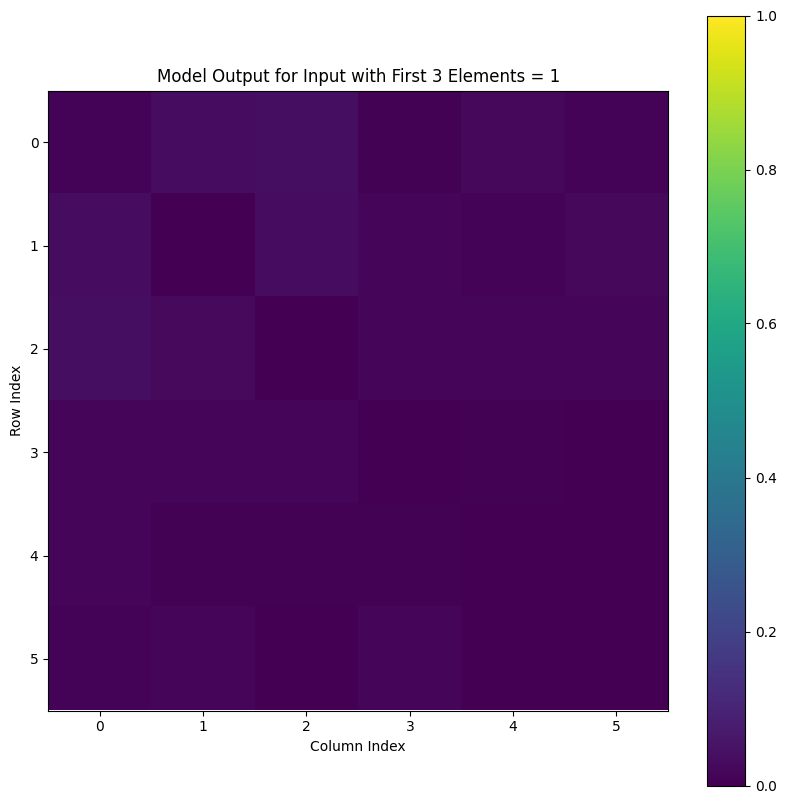

In [111]:

# Test the model
def test_model(model):
    with torch.no_grad():
        test_inputs = random_sparse_inputs(1000)
        test_outputs = model(test_inputs)
        expected_outputs = compute_expected(test_inputs)
        test_loss = criterion(test_outputs, expected_outputs)
        return test_loss
    
# Compute the loss
test_loss = test_model(model)
print(f'\nTest Loss: {test_loss.item():.6f}')

def plot_output(model):
# See the output for a particular input
    with torch.no_grad():
        test_input = torch.zeros(1, m, device=device)
        test_input[0, 0:k] = 1
        test_output = model(test_input)
    k2 = k * 2
    test_output_mini = test_output[0].reshape(m, m)[:k2, :k2]
    print(test_output_mini)
    # Visualize the test output as a heatmap, with values normalized between 0 and 1
    plt.figure(figsize=(10, 10))
    plt.imshow(test_output_mini.cpu().numpy(), cmap='viridis')
    plt.clim(0, 1)
    plt.colorbar()
    plt.title(f'Model Output for Input with First {k} Elements = 1')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

plot_output(model)

100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


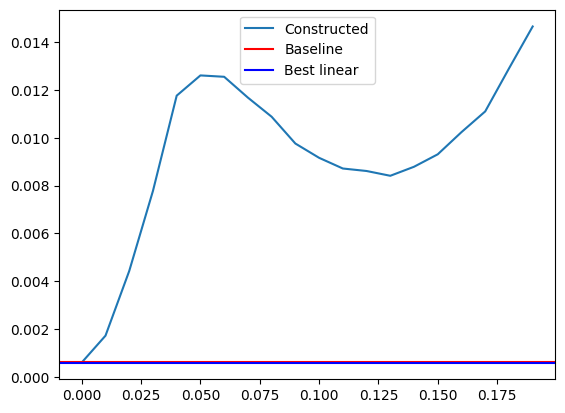

In [112]:
# Loss from a model that just outputs 0
baseline = k*(k-1)/m/m
# Loss from a model that can solve an arbitrary 2m of the m*m outputs
best_linear=(k*(k-1))/m/m * (m*m - 2*m)/m/m


x = []
y = []
for p in tqdm.tqdm(torch.arange(0, 0.2, 0.01)):
    model = construct_model(p)
    test_loss = test_model(model)
    # print(f"{p=} {test_loss=}")
    x.append(p)
    y.append(test_loss)
plt.plot(x, y, label='Constructed')
plt.axhline(baseline, color='red', label='Baseline')
plt.axhline(best_linear, color='blue', label='Best linear')
plt.legend()
plt.show()


In [113]:
print(baseline)

0.0006
